## Importing Modules

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('/home/junhokang/script')
import scjp

2022-01-20 08:40:02.606517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 08:40:02.606558: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import numpy as np
import scipy as scipy
import scanpy as sc
import scanpy.external as sce
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
import pickle as pkl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,8]
import seaborn as sns
from collections import defaultdict, Counter
import networkx as nx
import igraph, re, glob
from bbknn import bbknn
from geosketch import gs
import scrublet as scr
import joblib as jl
from datetime import datetime
def timestamp():
    return datetime.now().strftime("%y%m%d%H%M")
import logging
import scipy.stats
import diffxpy.api as de
from SCCAF import *
import gseapy
import scvelo as scv
import cellrank as cr

In [3]:
# setting scanpy
%matplotlib inline
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, color_map='OrRd')
sc.logging.print_version_and_date()

Running Scanpy 1.8.1, on 2022-01-20 08:40.


In [4]:
nb_name = 'MOG15.v03.MOG3_MS_newPropTest_cellprop_211208'
version = '.'.join(nb_name.split('.')[:2])+'.'
data = '_'.join(nb_name.split('.')[-1:][0].split('_')[:-2])
print('Version:', version)
print('Data:', data)

Version: MOG15.v03.
Data: MOG3_MS_newPropTest


In [5]:
base_folder = '/home/junhokang/projects/02_mogad_new/'

## Loading Adata (MOG3+MSpub)

In [11]:
adata = sc.read('./write/MOG15.v04.MOG3_MSpub_merge_raw_211228.h5ad')

Only considering the two last: ['.MOG3_MSpub_merge_raw_211228', '.h5ad'].
Only considering the two last: ['.MOG3_MSpub_merge_raw_211228', '.h5ad'].


## Boxplot of n_genes, n_counts

v2_figures/SF1.MSpub_ngenes.pdf


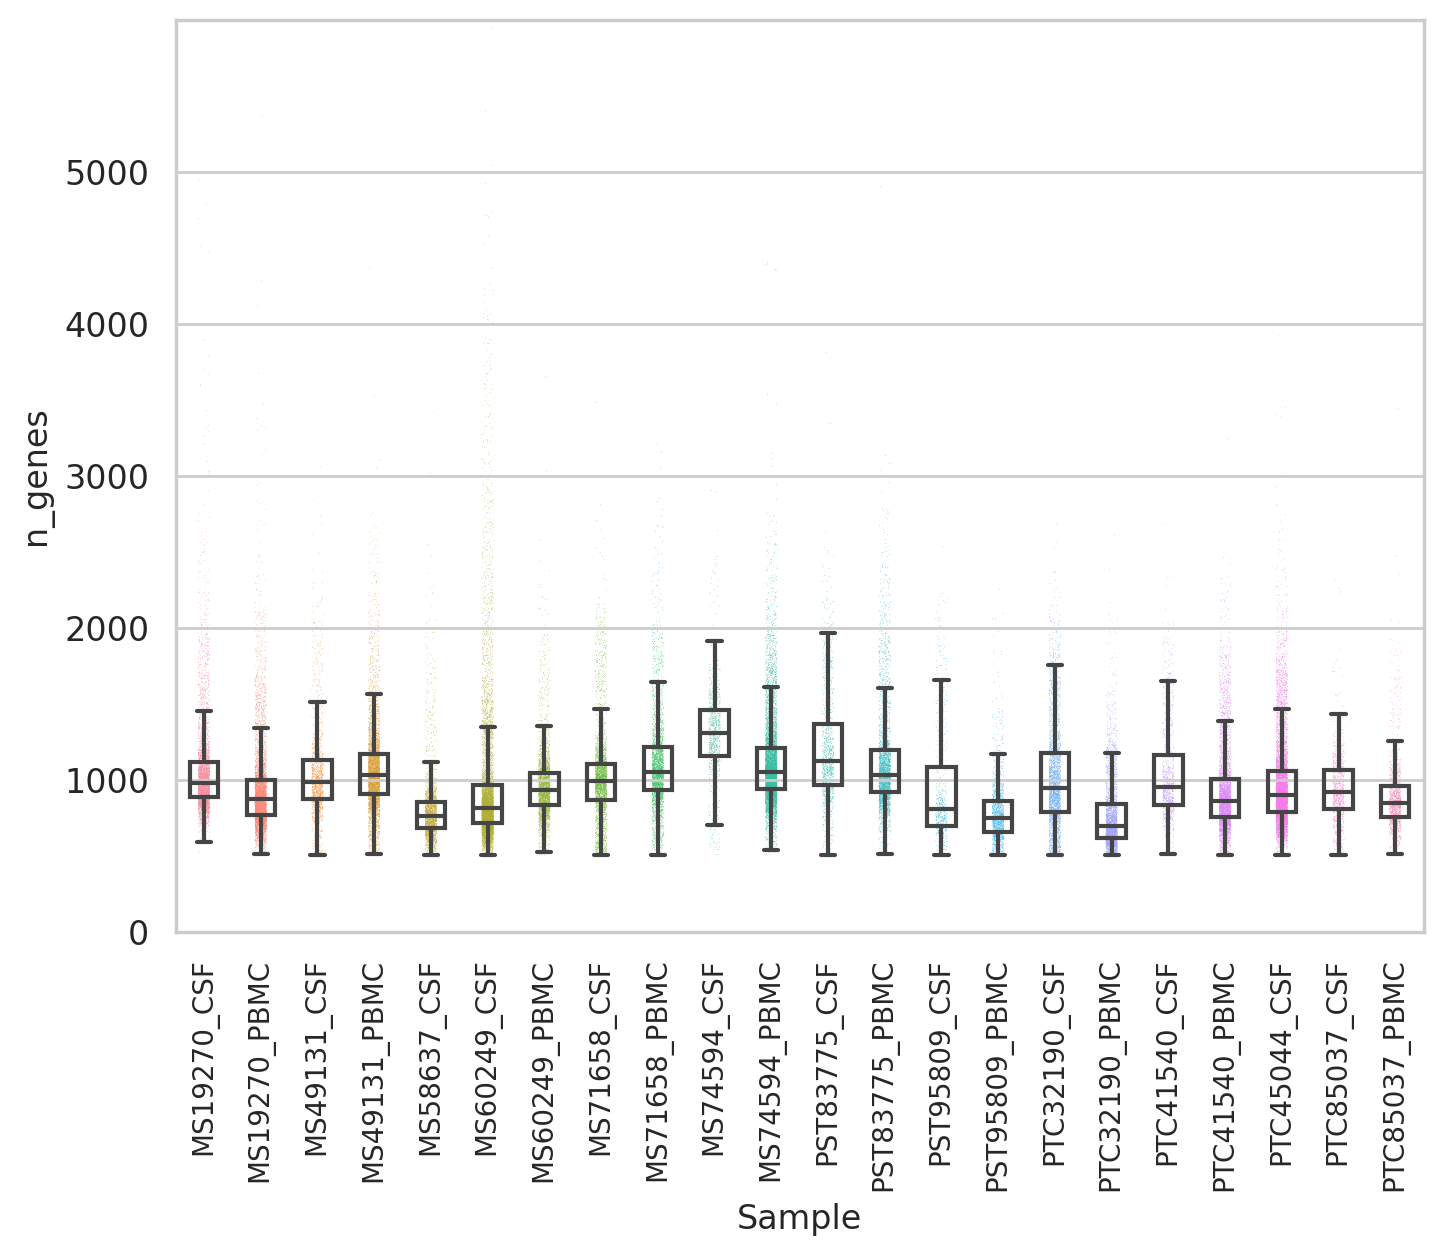

In [132]:
plt.rcParams["figure.figsize"]=[8,6]
public=adata[adata.obs['Source']=='Public']
sns.set_style('whitegrid')
sns.stripplot(x='Sample',y='n_genes',data=public.obs,size=0.25,jitter=True,zorder=0,rasterized=True)
sns.boxplot(x='Sample',y='n_genes',data=public.obs,fliersize=0,width=0.5,boxprops={'facecolor':'None'})
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(np.arange(0,6000,1000),fontsize=12)
plt.ylim(0,6000)
scjp.save_fig('SF1.','MSpub_ngenes',fig_folder='v2_figures',dpi=150)

v2_figures/SF1.MSpub_ncounts.pdf


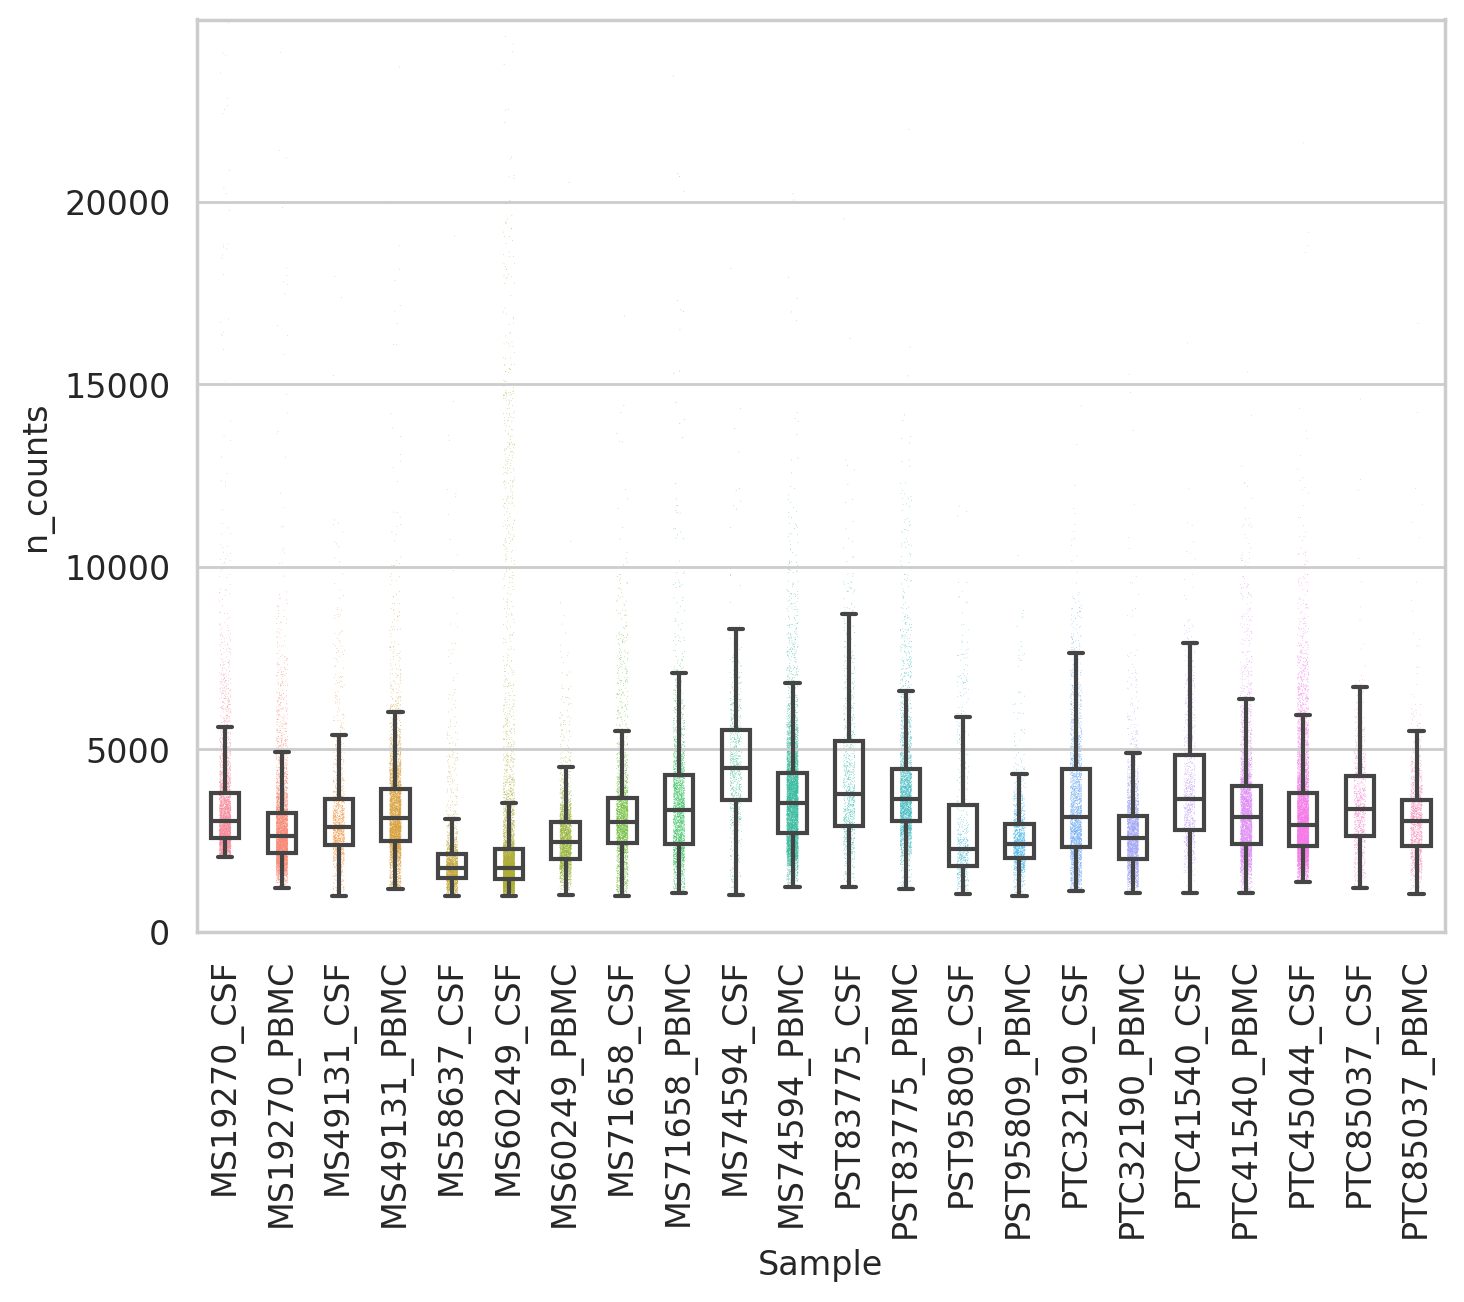

In [133]:
plt.rcParams["figure.figsize"]=[8,6]
public=adata[adata.obs['Source']=='Public']
sns.set_style('whitegrid')
sns.boxplot(x='Sample',y='n_counts',data=public.obs,fliersize=0,width=0.5,boxprops={'facecolor':'None'})
sns.stripplot(x='Sample',y='n_counts',data=public.obs,size=0.25,jitter=True,zorder=0,rasterized=True)
plt.xticks(fontsize=12, rotation = 90)
plt.yticks(np.arange(0,25000,5000),fontsize=12)
plt.ylim(0,25000)
scjp.save_fig('SF1.','MSpub_ncounts',fig_folder='v2_figures',dpi=150)

v2_figures/SF1.MOG3_ngenes.pdf


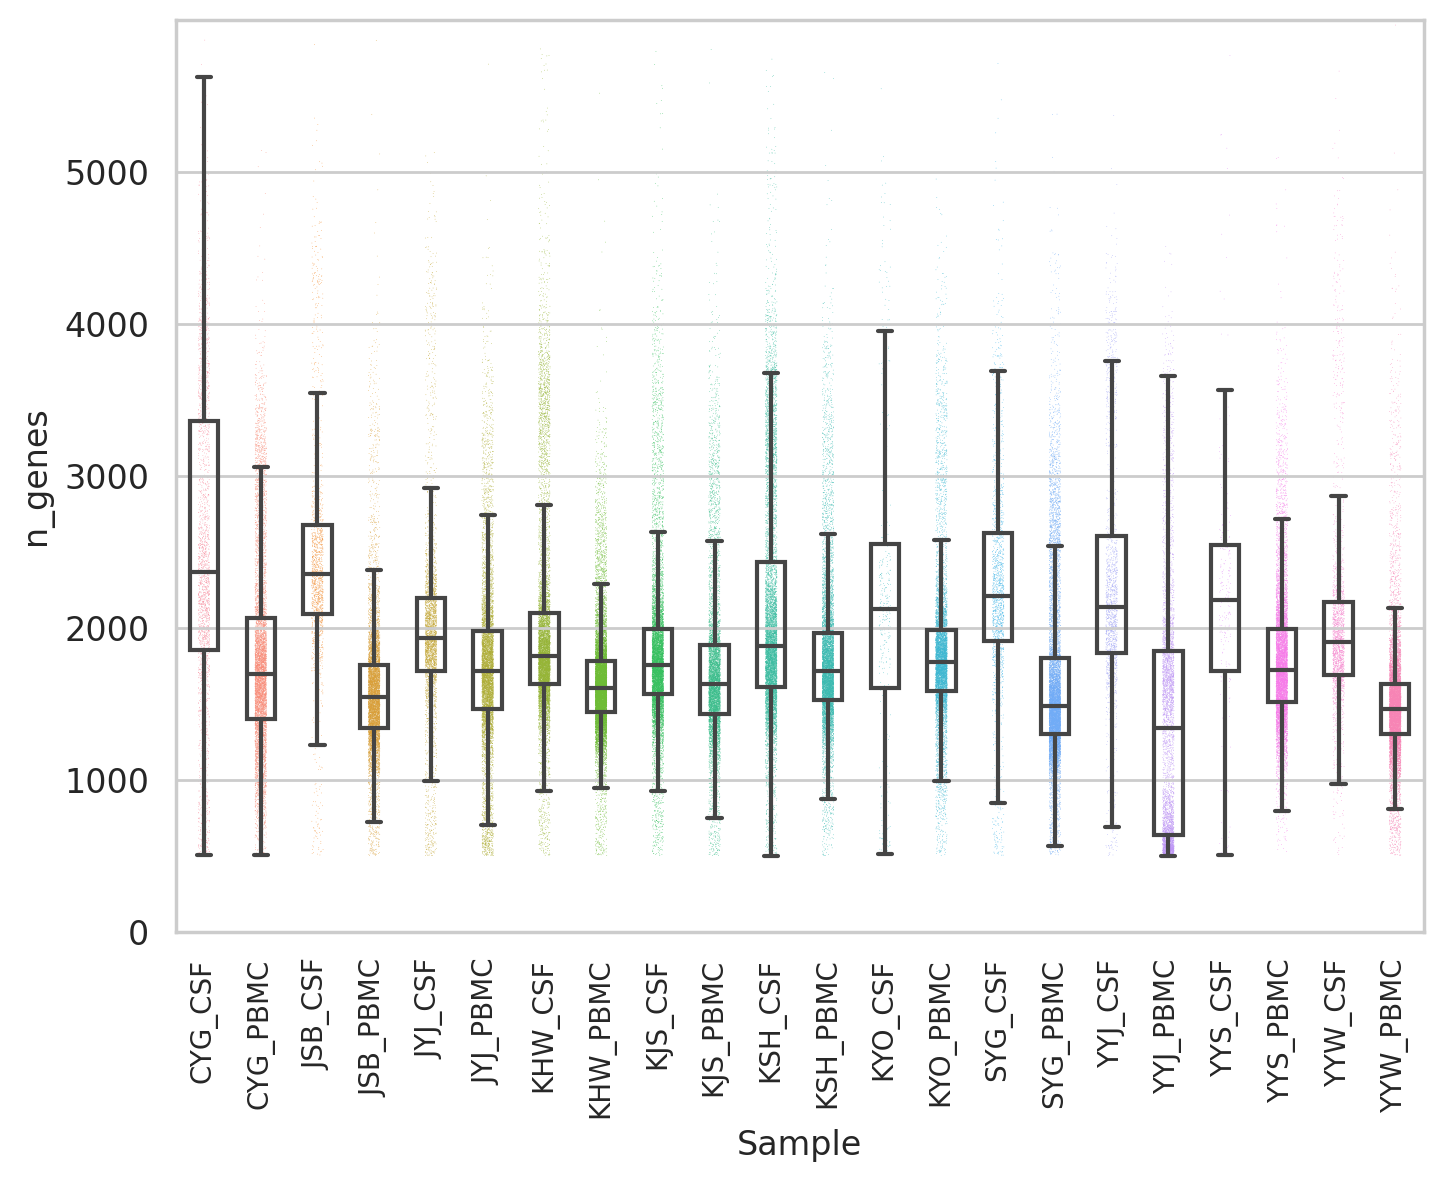

In [134]:
plt.rcParams["figure.figsize"]=[8,6]
private=adata[adata.obs['Source']!='Public']
sns.set_style('whitegrid')
sns.boxplot(x='Sample',y='n_genes',data=private.obs,fliersize=0,width=0.5,boxprops={'facecolor':'None'})
sns.stripplot(x='Sample',y='n_genes',data=private.obs,size=0.25,jitter=True,zorder=0,rasterized=True)
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(np.arange(0,6000,1000),fontsize=12)
plt.ylim(0,6000)
scjp.save_fig('SF1.','MOG3_ngenes',fig_folder='v2_figures',dpi=150)

v2_figures/SF1.MOG3_ncounts.pdf


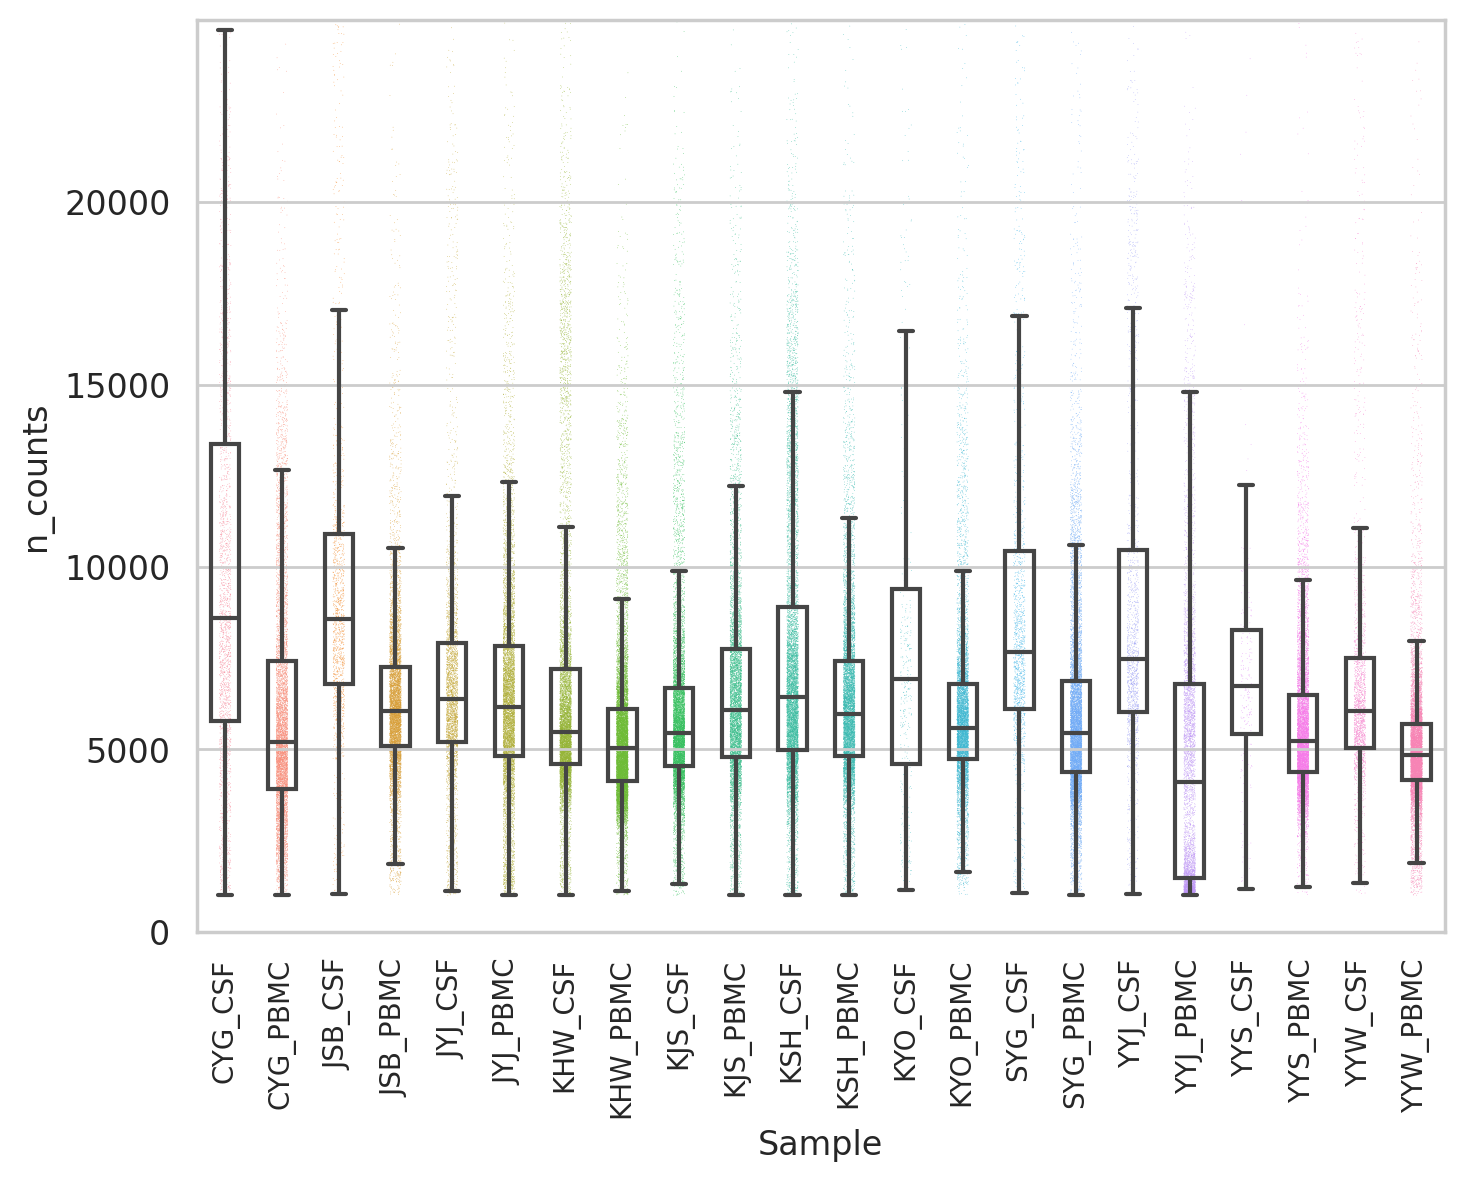

In [135]:
plt.rcParams["figure.figsize"]=[8,6]
private=adata[adata.obs['Source']!='Public']
sns.set_style('whitegrid')
sns.boxplot(x='Sample',y='n_counts',data=private.obs,fliersize=0,width=0.5,boxprops={'facecolor':'None'})
sns.stripplot(x='Sample',y='n_counts',data=private.obs,size=0.25,jitter=True,zorder=0,rasterized=True)
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(np.arange(0,25000,5000),fontsize=12)
plt.ylim(0,25000)
scjp.save_fig('SF1.','MOG3_ncounts',fig_folder='v2_figures',dpi=150)

In [194]:
source_list=['Private' if 'SNUH' in x else x for x in adata.obs.Source]

ngene_df=adata.obs.groupby('Sample').mean()
ngene_dict={a:b for a,b in zip(ngene_df.index,ngene_df.n_genes)}

source_list=['Private' if 'SNUH' in x else x for x in adata.obs.Source]
source={i:z for i, z in zip(adata.obs.Sample,source_list)}
tissue={i:z for i, z in zip(adata.obs.Sample,adata.obs.Tissue)}
prop = pd.crosstab(adata.obs['Sample'], adata.obs['Chemistry'])
df = prop.reset_index().melt(id_vars='Sample')
df['Source'] = [source[x] for x in df['Sample']]
df['Tissue'] = [tissue[x] for x in df['Sample']]
df['n_genes'] = [ngene_dict[x] for x in df['Sample']]

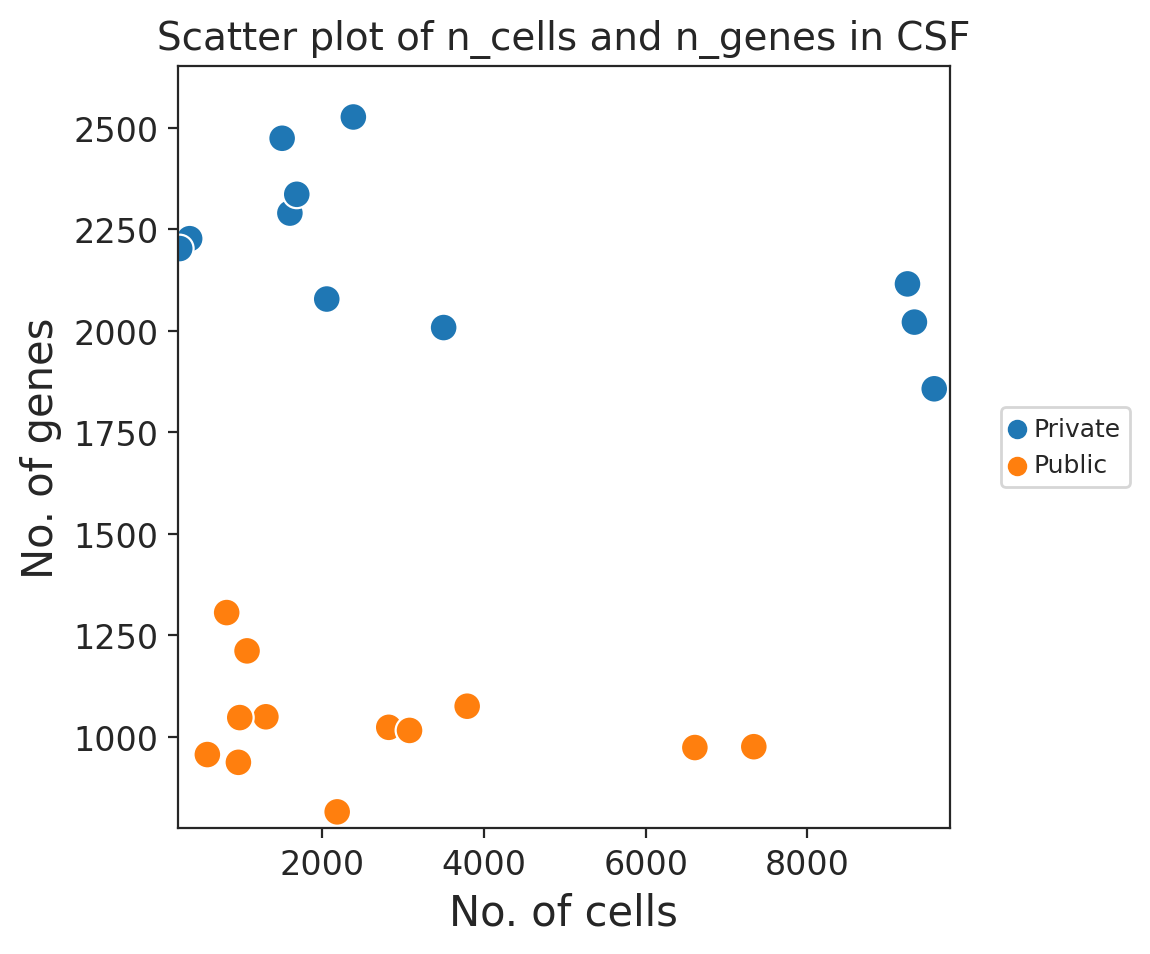

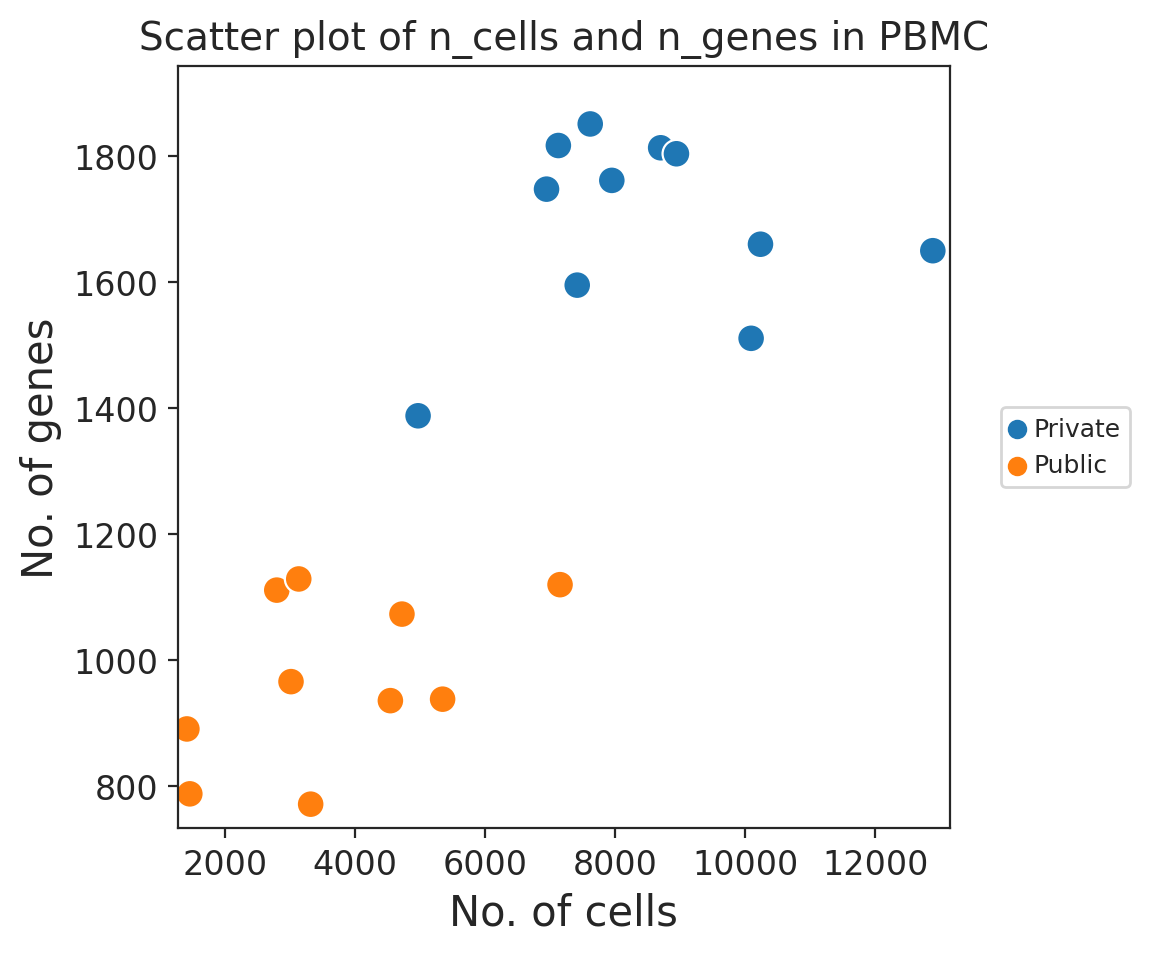

In [41]:
for f in ['CSF','PBMC']:
    temp = df[df['Tissue']==f]
    plt.figure(figsize=(6,5))
    sns.set_style("ticks")
    sns.scatterplot(x='value',y='n_genes',data=temp,hue='Source',s=100)
    plt.xlim(np.min(temp['value']*0.90),np.max(temp['value']*1.02))
    plt.ylim(np.min(temp['n_genes']*0.95),np.max(temp['n_genes']*1.05))
    plt.legend(bbox_to_anchor=(1.05, 0.5),loc='center left',fontsize=9)
    plt.title('Scatter plot of n_cells and n_genes in {}'.format(f),fontsize=14)
    plt.xlabel('No. of cells',fontsize=15)
    plt.ylabel('No. of genes',fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    #scjp.save_fig('SF1.','ncell_ngene_corr_{}'.format(f),fig_folder='v2_figures')
    #plt.clf()
    plt.show()

## PropTest

In [204]:
colors = np.asarray(scjp.colors.godsnot_64)
color={}
for i,f in enumerate(sorted(set(adata.obs['anno_final']))):
    color[f]=colors[i]

In [309]:
with open('./write/anno_jp_final_color_total.pkl','rb') as fr:
    color_total = pkl.load(fr)

In [311]:
color_total['T_CD4_memory']=color_total.pop('T_CD4_Th1')
color_total['T_CD8_memory']=color_total.pop('T_CD8_Trm')
color_total['B_memory']='#4fc601'

In [313]:
from scipy.stats import ttest_ind, mannwhitneyu
def celltypedf(ref_df,compare,comp_key,subset=None,subset_key=None):
    df = pd.DataFrame(index=cell_list)
    pval = {}
    fc = {}
    for i,f in enumerate(cell_list):
        temp = ref_df[ref_df['anno_final']==f]
        if subset:
            temp = temp[temp[subset]==subset_key]
        pval[f]=mannwhitneyu(temp[temp[compare]==comp_key]['value'],temp[temp[compare]!=comp_key]['value'])[1]
        fc[f]=(np.mean(temp[temp[compare]==comp_key]['value'])+0.0001)/(np.mean(temp[temp[compare]!=comp_key]['value'])+0.0001)
    df['fold_change'] = [fc[x] for x in df.index]
    df['pvalue'] = [pval[x] for x in df.index]
    df['colors'] = [color_total[x] for x in df.index]
    df = df.sort_values('fold_change',ascending=True)
    return df

In [294]:
def celltypedotplot(df,title,legend=False,xlim=6,ylim=5.5,xtext=0.3,ytext=0.15):
    for index, row in df.iterrows():
        if row['pvalue']==0: row['pvalue']=1e-5
        plt.scatter(np.log2(row['fold_change']),-np.log10(row['pvalue']),edgecolors='dimgray',
                   color=row['colors'],label=index,s=150)
        if legend==True:
            plt.legend(bbox_to_anchor=(1.1, 0.5),loc='center left', borderaxespad=0, fontsize=8)
        if (-np.log10(row['pvalue'])>1):
            plt.text(np.log2(row['fold_change'])-xtext,-np.log10(row['pvalue'])+ytext,index,color=row['colors'],fontsize=12)       
        if (np.log10(row['pvalue'])>1):
            plt.text(np.log2(row['fold_change'])-xtext,-np.log10(row['pvalue'])+ytext,index,color=row['colors'],fontsize=12)      
    plt.xlim(-xlim,xlim)    
    plt.ylim(-0.1,ylim)
    plt.axhline(y=1, color='blue', linestyle='--',zorder=-16)
    plt.axvline(x=0, color='midnightblue',alpha=0.7,zorder=-15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('log2 Fold Change', fontsize=15)
    plt.ylabel('-log10 p-value', fontsize=15)
    plt.axhline(y=1.3, color='red', linestyle='--',zorder=-16)
    plt.title(title,fontsize=15)
    plt.grid(False)
    sns.set_style("ticks")

In [314]:
cell_list = sorted(list(set(adata.obs['anno_final'])))
DiseaseCode = {i:z for i,z in zip(adata.obs.Sample,adata.obs.DiseaseCode)}
Disease = {i:z for i,z in zip(adata.obs.Sample,adata.obs.Disease)}
PatientID = {i:z for i,z in zip(adata.obs.Sample,adata.obs.PatientID)}
Source = {i:z for i,z in zip(adata.obs.Sample,adata.obs.Source)}
Tissue = {i:z for i,z in zip(adata.obs.Sample,adata.obs.Tissue)}

In [315]:
prop = pd.crosstab(adata.obs['Sample'], adata.obs['anno_final'], normalize=0)
a_df = prop.reset_index().melt(id_vars='Sample')
a_df['DiseaseCode'] = [DiseaseCode[x] for x in a_df['Sample']]
a_df['DiseaseCode'] = ['NMOSD' if 'NMOSD' in x else x for x in a_df['DiseaseCode']]
a_df['Disease'] = [Disease[x] for x in a_df['Sample']]
a_df['PatientID'] = [PatientID[x] for x in a_df['Sample']]
a_df['Source'] = [Source[x] for x in a_df['Sample']]
a_df['Tissue'] = [Tissue[x] for x in a_df['Sample']]

v2_figures/F1D.CTvolcano_CSFPBMC.pdf


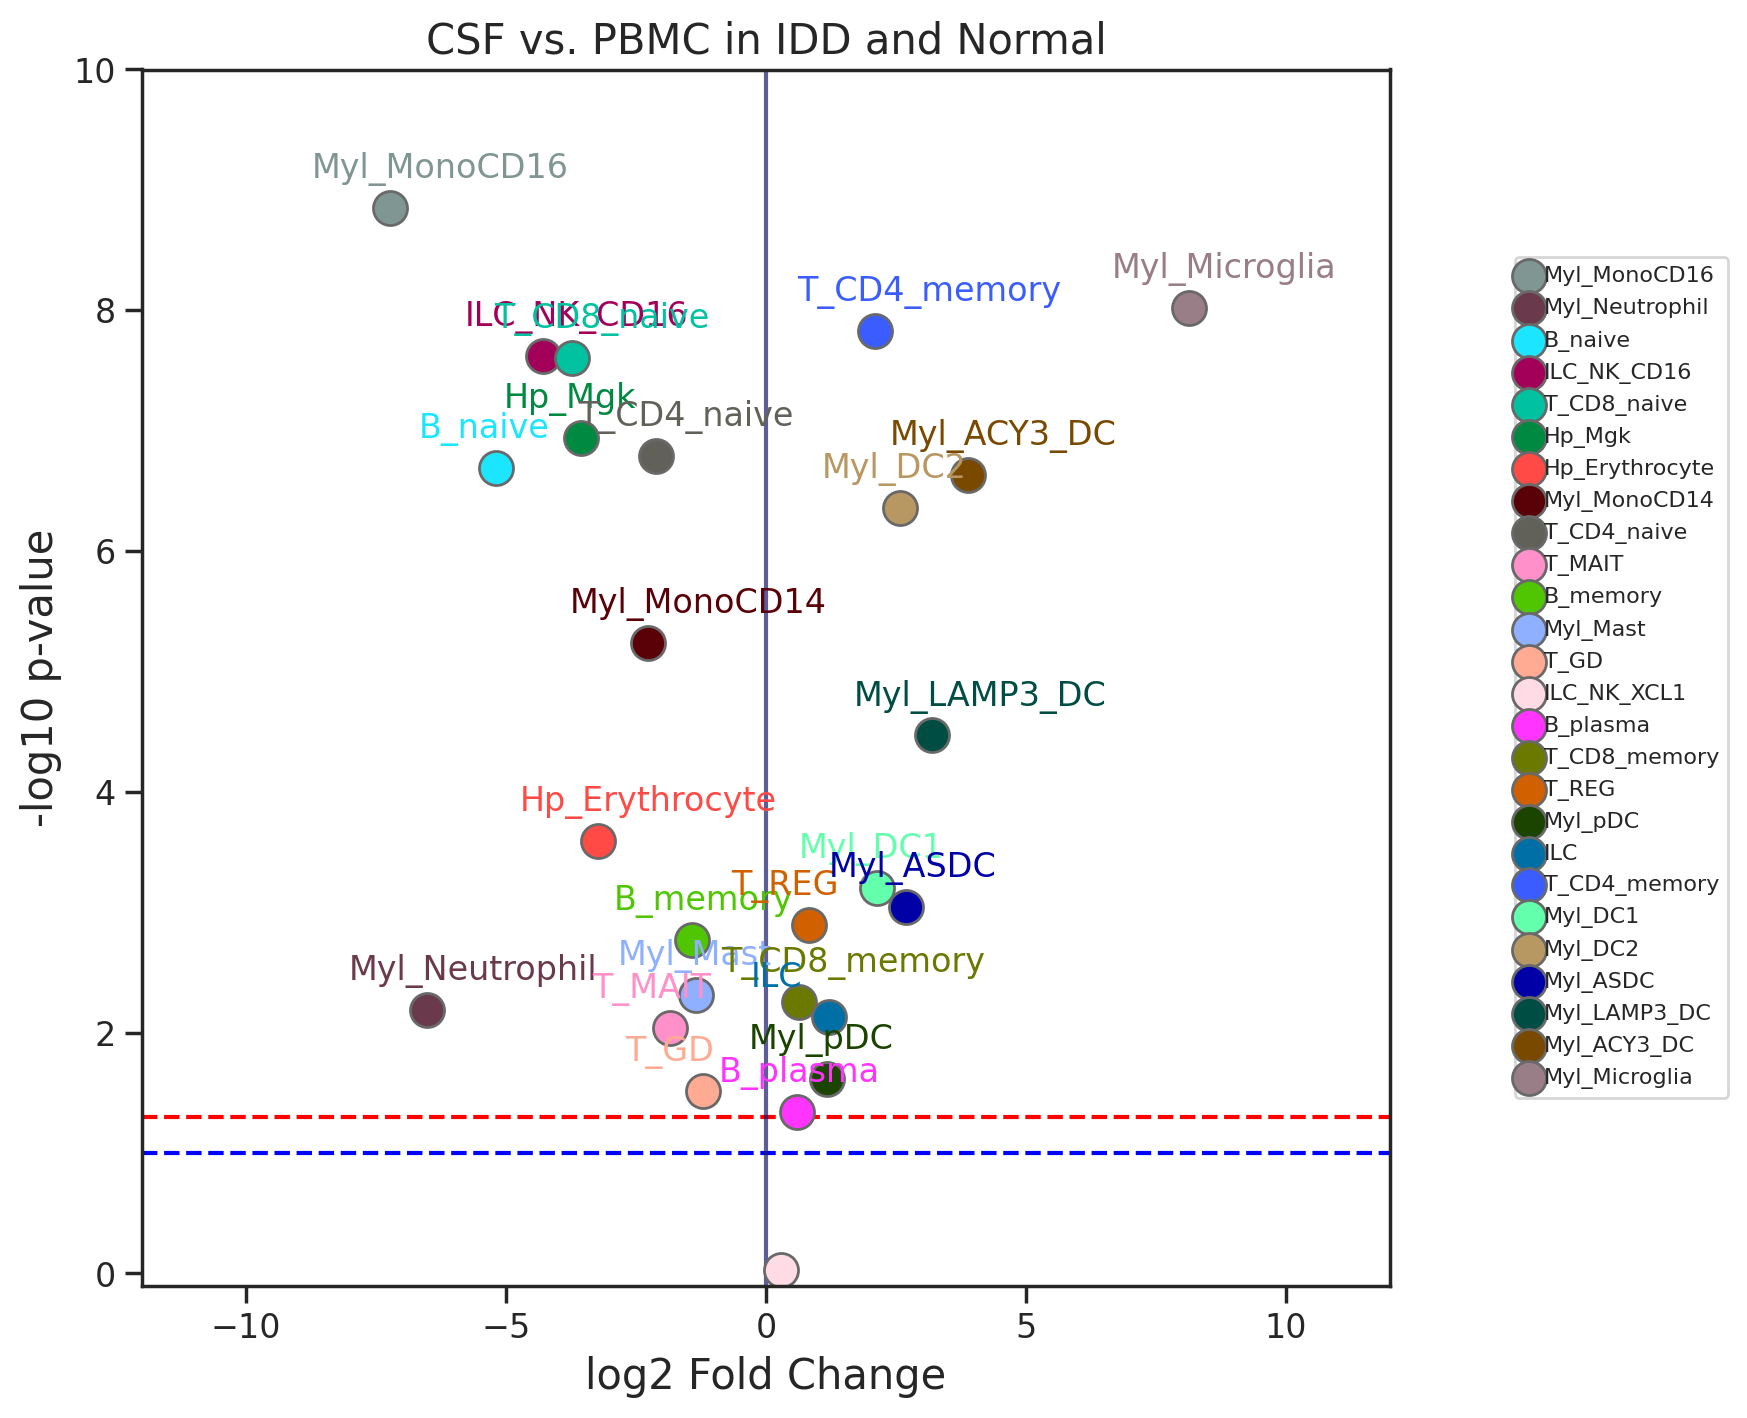

In [316]:
title='CSF vs. PBMC in IDD and Normal'
df = celltypedf(a_df,compare='Tissue',comp_key='CSF')
plt.figure(figsize=(8,8))
celltypedotplot(df,title,legend=True,xlim=12,ylim=10,xtext=1.5,ytext=0.25)
scjp.save_fig('F1D.','CTvolcano_CSFPBMC',fig_folder='v2_figures')

v2_figures/F1E.CTvolcano_DzNor.pdf


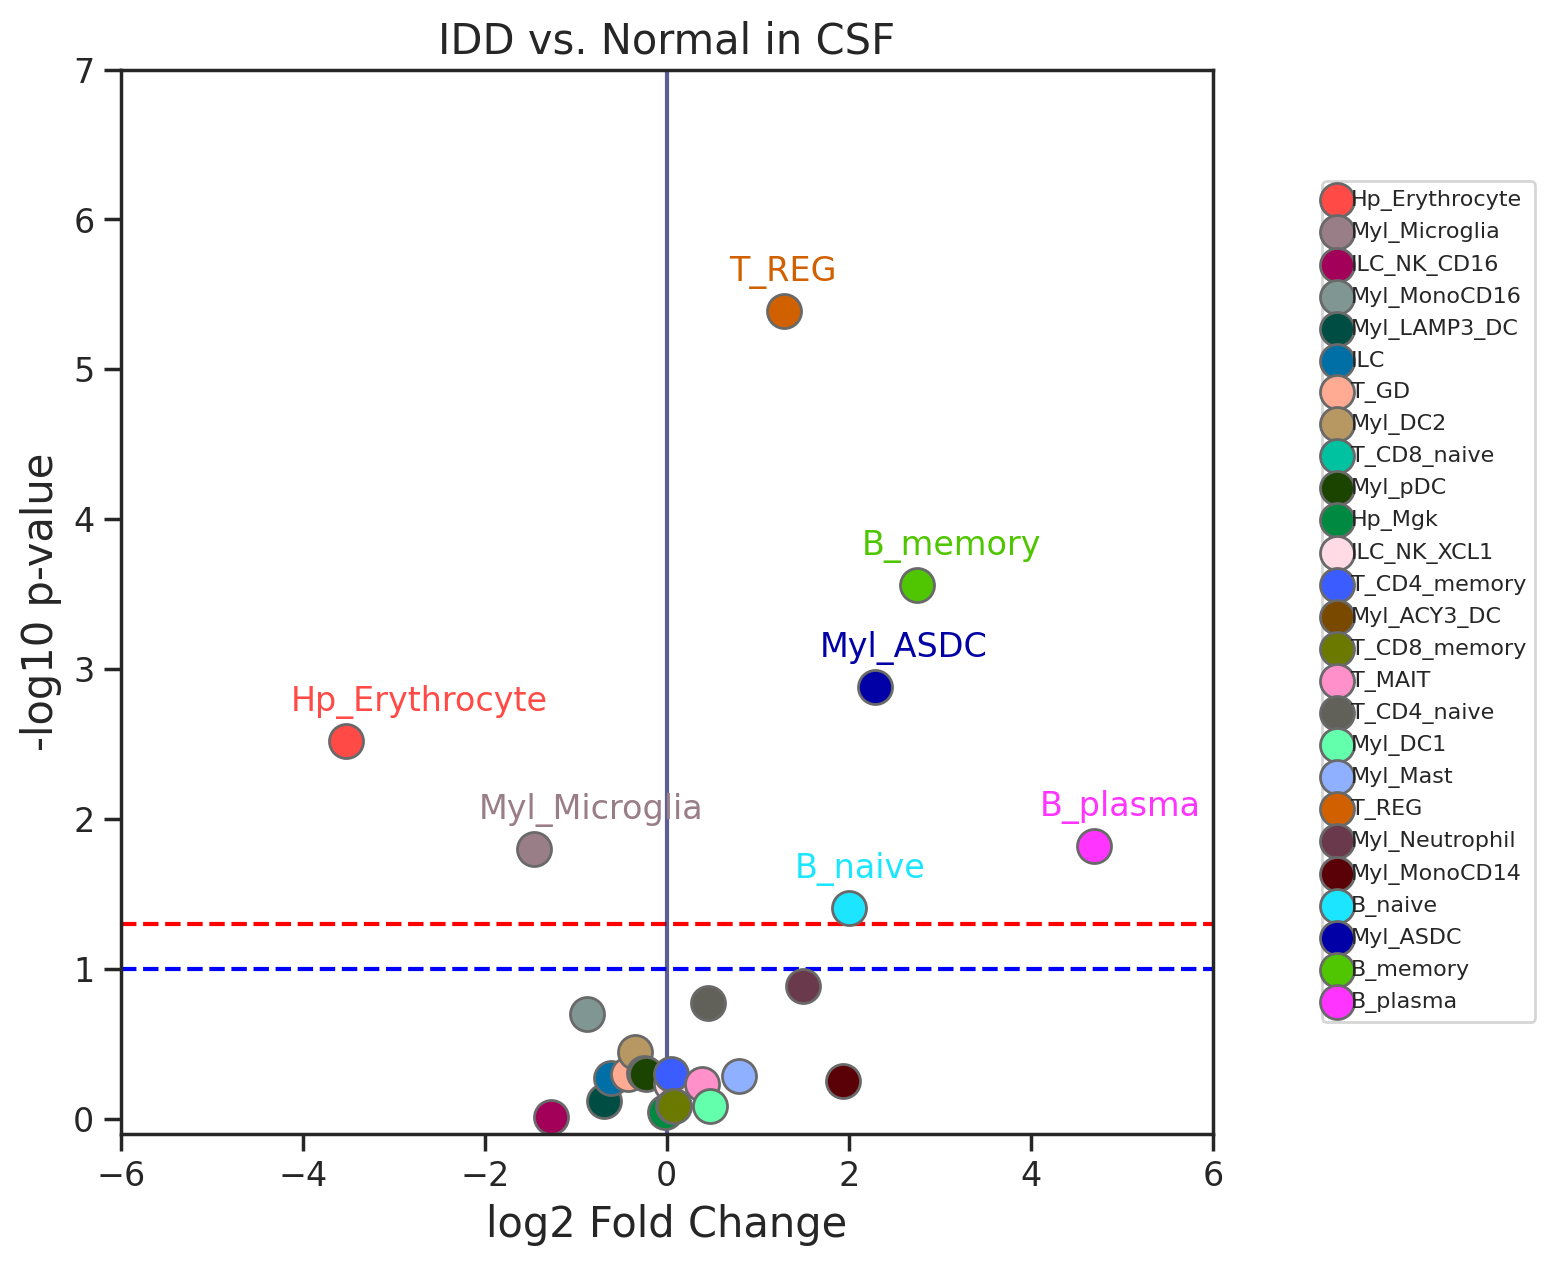

In [317]:
title='IDD vs. Normal in CSF'
df = celltypedf(a_df,compare='Disease',comp_key='Disease',subset='Tissue',subset_key='CSF')
plt.figure(figsize=(7,7))
celltypedotplot(df,title,legend=True,ylim=7,xtext=0.6,ytext=0.2)
scjp.save_fig('F1E.','CTvolcano_DzNor',fig_folder='v2_figures')

## CellProp

### T cell & ILC, CSF

In [338]:
t = [x for x in set(adata.obs['anno_final']) if x.startswith('T_')]
ilc = [x for x in set(adata.obs['anno_final']) if x.startswith('ILC')]
t = t+ilc
tdata = adata[(adata.obs['anno_final'].isin(t)) & (adata.obs['Tissue']=='CSF')]

In [339]:
Count = dict(Counter(tdata.obs['Sample']))

In [340]:
for f in Count.keys():
    if Count[f] < 101:
        print(f,'will be removed')
    else:
        continue

In [341]:
cell_list = sorted(list(set(tdata.obs['anno_final'])))
DiseaseCode = {i:z for i, z in zip(tdata.obs.Sample,tdata.obs.DiseaseCode)}
Disease = {i:z for i, z in zip(tdata.obs.Sample,tdata.obs.Disease)}
PatientID = {i:z for i, z in zip(tdata.obs.Sample,tdata.obs.PatientID)}
Tissue = {i:z for i, z in zip(tdata.obs.Sample,tdata.obs.Tissue)}
DzCode = {i:z for i, z in zip(tdata.obs.Sample,tdata.obs.DzCode)}
Dzfig = {i:z for i, z in zip(tdata.obs.Sample,tdata.obs.Dzfig)}
Antibody = {i:z for i, z in zip(tdata.obs.Sample,tdata.obs.Antibody)}

In [342]:
prop = pd.crosstab(tdata.obs['Sample'], tdata.obs['anno_final'], normalize=0)
t_df = prop.reset_index().melt(id_vars='Sample')
t_df['DiseaseCode'] = [DiseaseCode[x] for x in t_df['Sample']]
t_df['DiseaseCode'] = ['NMOSD' if 'NMOSD' in x else x for x in t_df['DiseaseCode']]
t_df['Disease'] = [Disease[x] for x in t_df['Sample']]
t_df['PatientID'] = [PatientID[x] for x in t_df['Sample']]
t_df['Tissue'] = [Tissue[x] for x in t_df['Sample']]
t_df['DzCode'] = [DzCode[x] for x in t_df['Sample']]
t_df['Dzfig'] = [Dzfig[x] for x in t_df['Sample']]
t_df['Antibody'] = [Antibody[x] for x in t_df['Sample']]
t_df['Count'] = [Count[x] for x in t_df['Sample']]
t_df['Count'] = t_df['Count'].astype('float')
t_df = t_df[t_df['Count']>100]

In [343]:
colors = np.asarray(scjp.colors.vega_20_scanpy[4:])
color={}
for i,f in enumerate(sorted(set(t_df['Dzfig']))):
    color[f]=colors[i]

/tmp/ipykernel_31116/4214811672.py:43: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.T_REG_prop.pdf


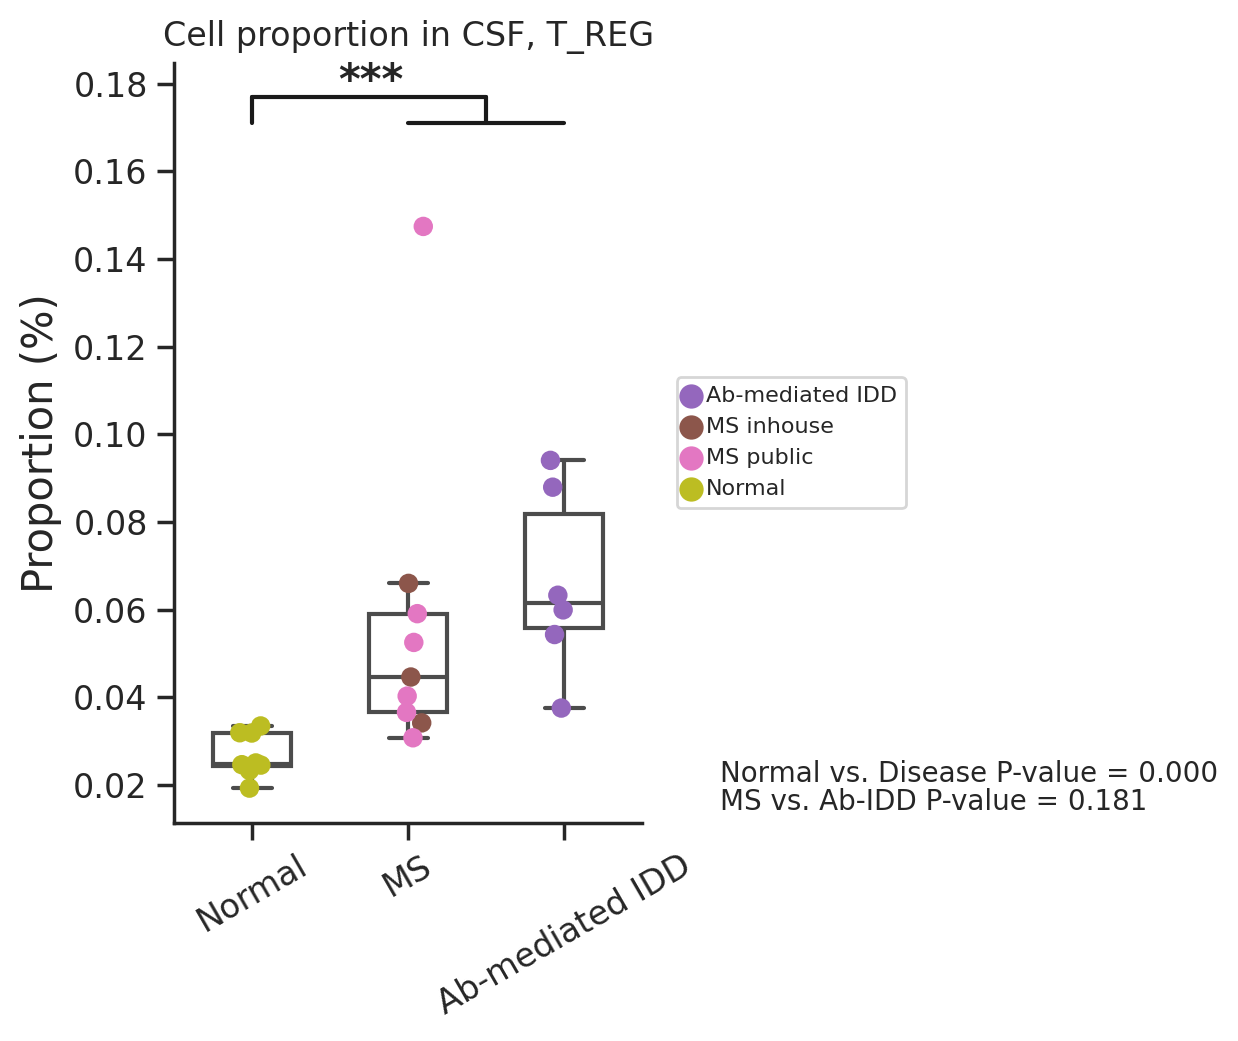

In [344]:
from scipy.stats import ttest_ind, mannwhitneyu
sns.set(rc={'figure.figsize':(3,5)})
for f in 'T_REG'.split(','):
    sns.set_style('ticks')
    order = 'Normal,MS,Ab-mediated IDD'.split(',')
    #col=[color[x] for x in sorted(set(t_df['dzcode']))]
    df=t_df[t_df['anno_final']==f].sort_values('Dzfig')
    x='DzCode'
    p1 = mannwhitneyu(df[df[x]=='Normal']['value'],df[df[x]!='Normal']['value'])[1]
    p2= mannwhitneyu(df[df[x]=='MS']['value'],df[df[x]=='Ab-mediated IDD']['value'])[1]
    sns.boxplot(x=x,y='value',data=df,order=order,fliersize=0,width=0.5,boxprops={'facecolor':'None'})
    sns.stripplot(x=x,y='value',data=df,order=order,hue='Dzfig',palette=color,size=7)
    plt.title("Cell proportion in CSF, {}".format(f))
    plt.legend(bbox_to_anchor=(1.05, 0.5),loc='center left',fontsize=8)
    plt.text(x=3,y=(np.min(df['value'])),s='Normal vs. Disease P-value = {:.3f}'.format(p1),fontsize=10,va='bottom')
    plt.text(x=3,y=np.min(df['value']),s='MS vs. Ab-IDD P-value = {:.3f}'.format(p2),fontsize=10,va='top')
    if p1 < 0.05:
        plt.plot([0,0],[np.max(df['value'])*1.16,np.max(df['value'])*1.20],'k-')
        plt.plot([1.5,1.5],[np.max(df['value'])*1.16,np.max(df['value'])*1.20],'k-')
        plt.plot([1,2],[np.max(df['value'])*1.16,np.max(df['value'])*1.16],'k-')
        plt.plot([0,1.5],[np.max(df['value'])*1.20,np.max(df['value'])*1.20],'k-')
        if p1<0.001:
            plt.text(0.55,np.max(df['value'])*1.205,'***',fontsize=15,weight='bold')
        elif p1<0.01:
            plt.text(0.6,np.max(df['value'])*1.205,'**',fontsize=15,weight='bold')
        else:
            plt.text(0.67,np.max(df['value'])*1.205,'*',fontsize=15,weight='bold')
    if p2 < 0.05:
        plt.plot([1,2],[np.max(df['value'])*1.07,np.max(df['value'])*1.07],'k-')
        plt.plot([1,1],[np.max(df['value'])*1.05,np.max(df['value'])*1.07],'k-')
        plt.plot([2,2],[np.max(df['value'])*1.05,np.max(df['value'])*1.07],'k-')
        if p2<0.001:
            plt.text(1.32,np.max(df['value'])*1.07,'***',fontsize=15,weight='bold')
        elif p2<0.01:
            plt.text(1.37,np.max(df['value'])*1.07,'**',fontsize=15,weight='bold')
        else:
            plt.text(1.42,np.max(df['value'])*1.07,'*',fontsize=15,weight='bold')
    plt.xlabel('')
    plt.ylabel('Proportion (%)', fontsize=15)
    plt.xticks(fontsize=12,rotation=30)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout()
    scjp.save_fig('F2.','{}_prop'.format(f),fig_folder='v2_figures')
    #plt.clf()
    plt.show()

### Myeloid, CSF

In [345]:
Myl = [x for x in set(sorted(adata.obs['anno_final'])) if 'Myl_' in x]
mdata = adata[(adata.obs['anno_final'].isin(Myl)) & (adata.obs['Tissue']=='CSF')]

In [346]:
Count = dict(Counter(mdata.obs['Sample']))

In [347]:
for f in Count.keys():
    if Count[f] < 101:
        print(f,'will be removed')
    else:
        continue

YYS_CSF will be removed
MS49131_CSF will be removed
PTC85037_CSF will be removed
MS74594_CSF will be removed


In [348]:
cell_list = sorted(list(set(mdata.obs['anno_final'])))
DiseaseCode = {i:z for i, z in zip(mdata.obs.Sample,mdata.obs.DiseaseCode)}
Disease = {i:z for i, z in zip(mdata.obs.Sample,mdata.obs.Disease)}
PatientID = {i:z for i, z in zip(mdata.obs.Sample,mdata.obs.PatientID)}
Tissue = {i:z for i, z in zip(mdata.obs.Sample,mdata.obs.Tissue)}
DzCode = {i:z for i, z in zip(mdata.obs.Sample,mdata.obs.DzCode)}
Dzfig = {i:z for i, z in zip(mdata.obs.Sample,mdata.obs.Dzfig)}
Antibody = {i:z for i, z in zip(mdata.obs.Sample,mdata.obs.Antibody)}

In [349]:
prop = pd.crosstab(mdata.obs['Sample'], mdata.obs['anno_final'], normalize=0)
m_df = prop.reset_index().melt(id_vars='Sample')
m_df['DiseaseCode'] = [DiseaseCode[x] for x in m_df['Sample']]
m_df['DiseaseCode'] = ['NMOSD' if 'NMOSD' in x else x for x in m_df['DiseaseCode']]
m_df['Disease'] = [Disease[x] for x in m_df['Sample']]
m_df['PatientID'] = [PatientID[x] for x in m_df['Sample']]
m_df['Tissue'] = [Tissue[x] for x in m_df['Sample']]
m_df['DzCode'] = [DzCode[x] for x in m_df['Sample']]
m_df['Dzfig'] = [Dzfig[x] for x in m_df['Sample']]
m_df['Antibody'] = [Antibody[x] for x in m_df['Sample']]
m_df['Count'] = [Count[x] for x in m_df['Sample']]
m_df['Count'] = m_df['Count'].astype('float')
m_df = m_df[m_df['Count']>100]

In [350]:
from scipy.stats import ttest_ind, mannwhitneyu
sns.set(rc={'figure.figsize':(3,5)})
for f in 'Myl_Microglia,Myl_MonoCD14,Myl_Neutrophil'.split(','):
    sns.set_style('ticks')
    order = 'Normal,MS,Ab-mediated IDD'.split(',')
    df=m_df[m_df['anno_final']==f].sort_values('Dzfig')
    x='DzCode'
    p1 = mannwhitneyu(df[df[x]=='Normal']['value'],df[df[x]!='Normal']['value'])[1]
    p2= mannwhitneyu(df[df[x]=='MS']['value'],df[df[x]=='Ab-mediated IDD']['value'])[1]
    sns.boxplot(x=x,y='value',data=df,order=order,fliersize=0,width=0.5,boxprops={'facecolor':'None'})
    sns.stripplot(x=x,y='value',data=df,order=order,hue='Dzfig',palette=color,size=7)
    plt.title("Cell proportion in CSF, {}".format(f))
    plt.legend(bbox_to_anchor=(1.05, 0.5),loc='center left',fontsize=8)
    plt.text(x=3,y=(np.min(df['value'])),s='Normal vs. Disease P-value = {:.3f}'.format(p1),fontsize=10,va='bottom')
    plt.text(x=3,y=np.min(df['value']),s='MS vs. Ab-IDD P-value = {:.3f}'.format(p2),fontsize=10,va='top')
    if p1 < 0.05:
        plt.plot([0,0],[np.max(df['value'])*1.16,np.max(df['value'])*1.20],'k-')
        plt.plot([1.5,1.5],[np.max(df['value'])*1.16,np.max(df['value'])*1.20],'k-')
        plt.plot([1,2],[np.max(df['value'])*1.16,np.max(df['value'])*1.16],'k-')
        plt.plot([0,1.5],[np.max(df['value'])*1.20,np.max(df['value'])*1.20],'k-')
        if p1<0.001:
            plt.text(0.55,np.max(df['value'])*1.205,'***',fontsize=15,weight='bold')
        elif p1<0.01:
            plt.text(0.6,np.max(df['value'])*1.205,'**',fontsize=15,weight='bold')
        else:
            plt.text(0.67,np.max(df['value'])*1.205,'*',fontsize=15,weight='bold')
    if p2 < 0.05:
        plt.plot([1,2],[np.max(df['value'])*1.07,np.max(df['value'])*1.07],'k-')
        plt.plot([1,1],[np.max(df['value'])*1.05,np.max(df['value'])*1.07],'k-')
        plt.plot([2,2],[np.max(df['value'])*1.05,np.max(df['value'])*1.07],'k-')
        if p2<0.001:
            plt.text(1.32,np.max(df['value'])*1.07,'***',fontsize=15,weight='bold')
        elif p2<0.01:
            plt.text(1.37,np.max(df['value'])*1.07,'**',fontsize=15,weight='bold')
        else:
            plt.text(1.42,np.max(df['value'])*1.07,'*',fontsize=15,weight='bold')
    plt.xlabel('')
    plt.ylabel('Proportion (%)', fontsize=15)
    plt.xticks(fontsize=12,rotation=30)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout()
    scjp.save_fig('F2.','{}_prop'.format(f),fig_folder='v2_figures')
    plt.clf()
    #plt.show()

/tmp/ipykernel_31116/3244099339.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.Myl_Microglia_prop.pdf


/tmp/ipykernel_31116/3244099339.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.Myl_MonoCD14_prop.pdf


/tmp/ipykernel_31116/3244099339.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.Myl_Neutrophil_prop.pdf


<Figure size 300x500 with 0 Axes>

### DC, CSF

In [351]:
dc = [x for x in set(sorted(adata.obs['anno_final'])) if 'DC' in x]
dcdata = adata[(adata.obs['anno_final'].isin(dc)) & (adata.obs['Tissue']=='CSF')]

In [352]:
Count = dict(Counter(dcdata.obs['Sample']))

In [353]:
for f in Count.keys():
    if Count[f] < 51:
        print(f,'will be removed')
    else:
        continue

KYO_CSF will be removed
YYS_CSF will be removed
MS49131_CSF will be removed
PTC85037_CSF will be removed
MS74594_CSF will be removed


In [354]:
cell_list = sorted(list(set(dcdata.obs['anno_final'])))
DiseaseCode = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.DiseaseCode)}
Disease = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Disease)}
PatientID = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.PatientID)}
Tissue = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Tissue)}
DzCode = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.DzCode)}
Dzfig = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Dzfig)}
Antibody = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Antibody)}

In [355]:
prop = pd.crosstab(dcdata.obs['Sample'], dcdata.obs['anno_final'], normalize=0)
dc_df = prop.reset_index().melt(id_vars='Sample')
dc_df['DiseaseCode'] = [DiseaseCode[x] for x in dc_df['Sample']]
dc_df['DiseaseCode'] = ['NMOSD' if 'NMOSD' in x else x for x in dc_df['DiseaseCode']]
dc_df['Disease'] = [Disease[x] for x in dc_df['Sample']]
dc_df['PatientID'] = [PatientID[x] for x in dc_df['Sample']]
dc_df['Tissue'] = [Tissue[x] for x in dc_df['Sample']]
dc_df['DzCode'] = [DzCode[x] for x in dc_df['Sample']]
dc_df['Dzfig'] = [Dzfig[x] for x in dc_df['Sample']]
dc_df['Antibody'] = [Antibody[x] for x in dc_df['Sample']]
dc_df['Count'] = [Count[x] for x in dc_df['Sample']]
dc_df['Count'] = dc_df['Count'].astype('float')
dc_df = dc_df[dc_df['Count']>50]

In [356]:
from scipy.stats import ttest_ind, mannwhitneyu
sns.set(rc={'figure.figsize':(3,5)})
for f in cell_list:#'Myl_ACY3_DC,Myl_ASDC,Myl_LAMP3_DC,Myl_DC2'.split(','):
    sns.set_style('ticks')
    order = 'Normal,MS,Ab-mediated IDD'.split(',')
    df=dc_df[dc_df['anno_final']==f].sort_values('Dzfig')
    x='DzCode'
    p1 = mannwhitneyu(df[df[x]=='Normal']['value'],df[df[x]!='Normal']['value'])[1]
    p2= mannwhitneyu(df[df[x]=='MS']['value'],df[df[x]=='Ab-mediated IDD']['value'])[1]
    sns.boxplot(x=x,y='value',data=df,order=order,fliersize=0,width=0.5,boxprops={'facecolor':'None'})
    sns.stripplot(x=x,y='value',data=df,order=order,hue='Dzfig',palette=color,size=7)
    plt.title("Cell proportion in CSF, {}".format(f))
    plt.legend(bbox_to_anchor=(1.05, 0.5),loc='center left',fontsize=8)
    plt.text(x=3,y=(np.min(df['value'])),s='Normal vs. Disease P-value = {:.3f}'.format(p1),fontsize=10,va='bottom')
    plt.text(x=3,y=np.min(df['value']),s='MS vs. Ab-IDD P-value = {:.3f}'.format(p2),fontsize=10,va='top')
    if p1 < 0.05:
        plt.plot([0,0],[np.max(df['value'])*1.16,np.max(df['value'])*1.20],'k-')
        plt.plot([1.5,1.5],[np.max(df['value'])*1.16,np.max(df['value'])*1.20],'k-')
        plt.plot([1,2],[np.max(df['value'])*1.16,np.max(df['value'])*1.16],'k-')
        plt.plot([0,1.5],[np.max(df['value'])*1.20,np.max(df['value'])*1.20],'k-')
        if p1<0.001:
            plt.text(0.55,np.max(df['value'])*1.205,'***',fontsize=15,weight='bold')
        elif p1<0.01:
            plt.text(0.6,np.max(df['value'])*1.205,'**',fontsize=15,weight='bold')
        else:
            plt.text(0.67,np.max(df['value'])*1.205,'*',fontsize=15,weight='bold')
    if p2 < 0.05:
        plt.plot([1,2],[np.max(df['value'])*1.07,np.max(df['value'])*1.07],'k-')
        plt.plot([1,1],[np.max(df['value'])*1.05,np.max(df['value'])*1.07],'k-')
        plt.plot([2,2],[np.max(df['value'])*1.05,np.max(df['value'])*1.07],'k-')
        if p2<0.001:
            plt.text(1.32,np.max(df['value'])*1.07,'***',fontsize=15,weight='bold')
        elif p2<0.01:
            plt.text(1.37,np.max(df['value'])*1.07,'**',fontsize=15,weight='bold')
        else:
            plt.text(1.42,np.max(df['value'])*1.07,'*',fontsize=15,weight='bold')
    plt.xlabel('')
    plt.ylabel('Proportion (%)', fontsize=15)
    plt.xticks(fontsize=12,rotation=30)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout()
    scjp.save_fig('F2.','{}_prop'.format(f),fig_folder='v2_figures')
    plt.clf()
    #plt.show()

/tmp/ipykernel_31116/607744528.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.Myl_ACY3_DC_prop.pdf


/tmp/ipykernel_31116/607744528.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.Myl_ASDC_prop.pdf


/tmp/ipykernel_31116/607744528.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.Myl_DC1_prop.pdf


/tmp/ipykernel_31116/607744528.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.Myl_DC2_prop.pdf


/tmp/ipykernel_31116/607744528.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


v2_figures/F2.Myl_LAMP3_DC_prop.pdf
v2_figures/F2.Myl_pDC_prop.pdf


/tmp/ipykernel_31116/607744528.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


<Figure size 300x500 with 0 Axes>

## CellType-Correlation

### tDC vs. T-celltypes

In [324]:
dc = [x for x in set(sorted(adata.obs['anno_final'])) if 'DC' in x]
dcdata = adata[(adata.obs['anno_final'].isin(dc)) & (adata.obs['Tissue']=='CSF')]

In [325]:
Count = dict(Counter(dcdata.obs['Sample']))

In [326]:
for f in Count.keys():
    if Count[f] < 51:
        print(f,'will be removed')
    else:
        continue

KYO_CSF will be removed
YYS_CSF will be removed
MS49131_CSF will be removed
PTC85037_CSF will be removed
MS74594_CSF will be removed


In [327]:
cell_list = sorted(list(set(dcdata.obs['anno_final'])))
DiseaseCode = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.DiseaseCode)}
Disease = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Disease)}
PatientID = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.PatientID)}
Source = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Source)}
Tissue = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Tissue)}
Antibody = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Antibody)}
DzCode = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.DzCode)}
Dzfig = {i:z for i, z in zip(dcdata.obs.Sample,dcdata.obs.Dzfig)}

In [328]:
prop = pd.crosstab(dcdata.obs['Sample'], dcdata.obs['anno_final'], normalize=0)
dc_df = prop.reset_index().melt(id_vars='Sample')
dc_df['DiseaseCode'] = [DiseaseCode[x] for x in dc_df['Sample']]
dc_df['Disease'] = [Disease[x] for x in dc_df['Sample']]
dc_df['PatientID'] = [PatientID[x] for x in dc_df['Sample']]
dc_df['Source'] = [Source[x] for x in dc_df['Sample']]
dc_df['Tissue'] = [Tissue[x] for x in dc_df['Sample']]
dc_df['Antibody'] = [Antibody[x] for x in dc_df['Sample']]
dc_df['DzCode'] = [DzCode[x] for x in dc_df['Sample']]
dc_df['Dzfig'] = [Dzfig[x] for x in dc_df['Sample']]
dc_df['Count'] = [Count[x] for x in dc_df['Sample']]
dc_df['Count'] = dc_df['Count'].astype('float')
dc_df = dc_df[dc_df['Count']>50]

In [331]:
ASDC=dc_df[dc_df['anno_final']=='Myl_ASDC'].rename({'value':'ASDC'},axis='columns').sort_values('DiseaseCode')

In [334]:
for f in ['Myl_DC2','Myl_pDC']:
    temp = dc_df[dc_df['anno_final']==f]
    temp = {a:b for a,b in zip(temp['Sample'],temp['value'])}
    col=list(color.values())
    ASDC[f] = [temp[x] for x in ASDC['Sample']]
    r,p = scipy.stats.pearsonr(ASDC['ASDC'], ASDC[f])
    plt.figure(figsize=(6.5,5))
    sns.set_style("ticks")
    sns.regplot(x='ASDC', y=f,data=ASDC,scatter=False,color='silver',line_kws={'alpha':0.4, 'zorder':-2,'linewidth':4})
    sns.scatterplot(x='ASDC',y=f,data=ASDC,hue='Dzfig',s=100,palette=color)
    plt.text(x=np.max(ASDC['ASDC'])*1.05, y=np.min(ASDC[f])*0.99, s='Pearson r = {:.3f}\nP-value = {:.3f}'.format(r,p), fontsize=10)
    plt.xlim(np.min(ASDC['ASDC']*0.95),np.max(ASDC['ASDC']*1.02))
    plt.ylim(np.min(ASDC[f]*0.95),np.max(ASDC[f]*1.05))
    plt.legend(bbox_to_anchor=(1.05, 0.5),loc='center left',fontsize=9)
    plt.title('Correlation of ASDC and {} in CSF'.format(f),fontsize=14)
    plt.xlabel('Proportion(%) of ASDC',fontsize=15)
    plt.ylabel('Proportion(%) of {}'.format(f),fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    scjp.save_fig('F3D.','ASDC_{}_correlation'.format(f),fig_folder='v2_figures')
    plt.clf()
    #plt.show()

v2_figures/F3D.ASDC_Myl_DC2_correlation.pdf
v2_figures/F3D.ASDC_Myl_pDC_correlation.pdf


<Figure size 650x500 with 0 Axes>

<Figure size 650x500 with 0 Axes>

In [335]:
ACY3_DC=dc_df[dc_df['anno_final']=='Myl_ACY3_DC'].rename({'value':'ACY3_DC'},axis='columns').sort_values('DiseaseCode')

In [337]:
for f in ['Myl_DC2','Myl_DC1']:
    temp = dc_df[dc_df['anno_final']==f]
    temp = {a:b for a,b in zip(temp['Sample'],temp['value'])}
    ACY3_DC[f] = [temp[x] for x in ACY3_DC['Sample']]
    r,p = scipy.stats.pearsonr(ACY3_DC['ACY3_DC'], ACY3_DC[f])
    plt.figure(figsize=(6.5,5))
    sns.set_style("ticks")
    sns.regplot(x='ACY3_DC', y=f,data=ACY3_DC,scatter=False,color='silver',line_kws={'alpha':0.4, 'zorder':-2,'linewidth':4})
    sns.scatterplot(x='ACY3_DC',y=f,data=ACY3_DC,hue='Dzfig',s=100,palette=color)
    plt.text(x=np.max(ACY3_DC['ACY3_DC'])*1.05, y=np.min(ACY3_DC[f])*0.99, s='Pearson r = {:.3f}\nP-value = {:.3f}'.format(r,p), fontsize=10)
    plt.xlim(np.min(ACY3_DC['ACY3_DC']*0.95),np.max(ACY3_DC['ACY3_DC']*1.02))
    plt.ylim(np.min(ACY3_DC[f]*0.95),np.max(ACY3_DC[f]*1.05))
    plt.legend(bbox_to_anchor=(1.05, 0.5),loc='center left',fontsize=9)
    plt.title('Correlation of ACY3_DC and {} in CSF'.format(f),fontsize=14)
    plt.xlabel('Proportion(%) of ACY3_DC',fontsize=15)
    plt.ylabel('Proportion(%) of {}'.format(f),fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    scjp.save_fig('F3D.','ACY3_DC_{}_correlation'.format(f),fig_folder='v2_figures')
    plt.clf()
    #plt.show()

v2_figures/F3D.ACY3_DC_Myl_DC2_correlation.pdf
v2_figures/F3D.ACY3_DC_Myl_DC1_correlation.pdf


<Figure size 650x500 with 0 Axes>

<Figure size 650x500 with 0 Axes>